# Computing momentum budget in SUSTAIN

In this notebook, we'll combine multiple measurements to close the momentum budget in SUSTAIN.
Momentum budget allows us to estimate surface stress from along-tank mean slope, radiation stress,
and along-tank static pressure gradient.
This is useful in high wind speeds where spray can pollute the sonic anemometer measurement. 

From the momentum balance for water in the tank, assuming small nonlinear terms and steady state, we get:

$$
\tau = \rho_w g H \dfrac{\partial h}{\partial x} 
     + H \dfrac{\partial p}{\partial x}
     + \dfrac{\partial S_{xx}}{\partial x}
     - \tau_B
$$

where:

* $\tau$ is the surface stress [$N/m^2$]
* $H$ is the mean water elevation in the tank [m]
* $\rho_w$ is the water density [$kg/m^3$]
* $g$ is the gravitational acceleration [$m/s^2$]
* $\dfrac{\partial h}{\partial x}$ is the along-tank mean water slope
* $\dfrac{\partial p}{\partial x}$ is the along-tank mean static air pressure gradient [$N/m^3$]
* $\dfrac{\partial S_{xx}}{\partial x}$ is the along-tank radiation stress gradient [$N/m^2$]
* $\tau_B$ is the bottom stress [$N/m^2$]

In this analysis, we'll ignore $\tau_B$. However we should obtain it before submitting a paper.

In [1]:
from asist.utility import power_spectrum, cross_spectrum
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.signal import detrend
from scipy.stats import beta
from sustain_drag_2020.irgason import read_irgason_from_toa5, rotate
from sustain_drag_2020.udm import read_udm_from_toa5
from sustain_drag_2020.fetch import fetch
from sustain_drag_2020.dispersion import w2k
import warnings
warnings.filterwarnings('ignore')

import matplotlib
font = {'size': 16}
matplotlib.rc('font', **font)

## Wind and stress data

First read the sonic anemometer data and compute the mean wind and stress using eddy-covariance method:

$$
\tau = - \rho_w \overline{u'w'}
$$

In [2]:
def read_irgason_for_experiment(path, start_time):
    irgason_files = glob.glob(path + '/TOA5_SUSTAIN_Wind.FAST*.dat')
    return read_irgason_from_toa5(irgason_files, valid_flag=11)

In [3]:
experiments = [
    {'start_time': datetime(2019, 12,  3, 17, 30), 'fan': range(0, 55, 5)}, # wind-only, neutral, fresh, 0 - 50 Hz
    {'start_time': datetime(2020,  1,  9, 19, 36), 'fan': range(0, 55, 5)}, # wind + JONSWAP, stable, salt, 0 - 60 Hz 
    {'start_time': datetime(2020,  1, 10,  2, 40), 'fan': range(0, 55, 5)}, # wind + JONSWAP, unstable, salt, 0 - 60 Hz
    {'start_time': datetime(2020,  1, 10, 19, 48), 'fan': range(0, 55, 5)}, # wind + monochromatic, unstable, salt, 0 - 60 Hz
]

labels = [
    'Wind only, neutral',
    'JONSWAP, stable',
    'JONSWAP, unstable',
    'Monochromatic, unstable'
]

colors = ['g', 'y', 'r', 'm']

In [4]:
DATAPATH = '/home/milan/Work/sustain/data/sustain-drag-2020'
for exp in experiments:
    print(exp['start_time'])
    exp['data'] = read_irgason_for_experiment(DATAPATH + '/' + exp['start_time'].strftime('%Y%m%d'), exp['start_time'])

2019-12-03 17:30:00
Reading  TOA5_SUSTAIN_Wind.FAST_759_2019_12_03_1900.dat
Reading  TOA5_SUSTAIN_Wind.FAST_757_2019_12_03_1700.dat
Reading  TOA5_SUSTAIN_Wind.FAST_758_2019_12_03_1800.dat
Processing IRGASON time series..
2020-01-09 19:36:00
Reading  TOA5_SUSTAIN_Wind.FAST_4_2020_01_09_2000.dat
Reading  TOA5_SUSTAIN_Wind.FAST_5_2020_01_09_2100.dat
Reading  TOA5_SUSTAIN_Wind.FAST_3_2020_01_09_1900.dat
Processing IRGASON time series..
2020-01-10 02:40:00
Reading  TOA5_SUSTAIN_Wind.FAST_27_2020_01_10_1900.dat
Reading  TOA5_SUSTAIN_Wind.FAST_10_2020_01_10_0200.dat
Reading  TOA5_SUSTAIN_Wind.FAST_28_2020_01_10_2000.dat
Reading  TOA5_SUSTAIN_Wind.FAST_12_2020_01_10_0400.dat
Reading  TOA5_SUSTAIN_Wind.FAST_11_2020_01_10_0300.dat
Reading  TOA5_SUSTAIN_Wind.FAST_29_2020_01_10_2100.dat
Processing IRGASON time series..
2020-01-10 19:48:00
Reading  TOA5_SUSTAIN_Wind.FAST_27_2020_01_10_1900.dat
Reading  TOA5_SUSTAIN_Wind.FAST_10_2020_01_10_0200.dat
Reading  TOA5_SUSTAIN_Wind.FAST_28_2020_01_10_2000.

In [5]:
def eddy_covariance_flux(irg, time, t0, t1):
    """Eddy covariance flux from IRGASON, for a time subset between t0 and t1."""
    mask = (time >= t0) & (time <= t1)
    u, v, w = irg['u'][mask][:], irg['v'][mask][:], irg['w'][mask][:]
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U, W = np.nanmean(u), np.nanmean(w) # time mean
    up, wp = u - U, w - W # deviations from the mean
    uw = np.nanmean(up * wp) # stress
    good = ~np.isnan(u) & ~np.isnan(w)
    perc_good = (u[good].size / u.size) * 100 # percentage of data that is not bad
    return U, uw, perc_good

In [6]:
def sample_stress_uniform(irgason_data, time, start_time, run_seconds, sample_seconds, sampling):
    """Uniform-randomly sample IRGASON data and compute stress over given sample intervals."""
    num_runs, num_samples = sampling.shape
    U = np.zeros(sampling.shape)
    uw = np.zeros(sampling.shape)
    perc_good = np.zeros((num_runs, num_samples))
    for n in range(num_runs):
        for i in range(num_samples):
            t0 = start_time + timedelta(seconds=n * run_seconds + sampling[n,i])
            t1 = t0 + timedelta(seconds=sample_seconds)
            U[n,i], uw[n,i], perc_good[n,i] = eddy_covariance_flux(irgason_data, time, t0, t1)
    return U, uw, perc_good

In [7]:
sample_seconds = 60
run_seconds = 600
num_samples = 20

for n, exp in enumerate(experiments):
    num_runs = len(exp['fan'])
    print('Sampling stress for experiment ' + labels[n])
    sampling = np.random.uniform(size=(num_runs, num_samples)) * (run_seconds - sample_seconds)
    time, irg1, irg2 = exp['data']
    exp['U1'], exp['uw1'], exp['perc_good1'] = sample_stress_uniform(irg1, time, exp['start_time'], run_seconds, sample_seconds, sampling)
    exp['U2'], exp['uw2'], exp['perc_good2'] = sample_stress_uniform(irg2, time, exp['start_time'], run_seconds, sample_seconds, sampling)
    exp['sampling'] = sampling

Sampling stress for experiment Wind only, neutral
Sampling stress for experiment JONSWAP, stable
Sampling stress for experiment JONSWAP, unstable
Sampling stress for experiment Monochromatic, unstable


In [8]:
# mask out data where less than 99% of data was good
for n, exp in enumerate(experiments):
    num_runs = len(exp['fan'])
    for nrun in range(num_runs):
        good1 = exp['perc_good1'][nrun,:] > 99
        good2 = exp['perc_good2'][nrun,:] > 99
        exp['U1'][nrun,:][~good1] = np.nan
        exp['U2'][nrun,:][~good2] = np.nan
        exp['uw1'][nrun,:][~good1] = np.nan
        exp['uw2'][nrun,:][~good2] = np.nan

Text(0, 0.5, "$-\\overline{u'w'}$ [$m^2/s^2$]")

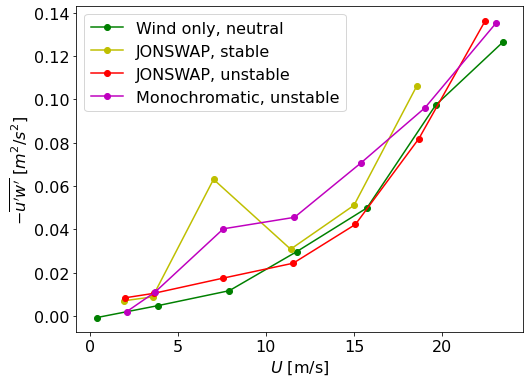

In [9]:
plt.figure(figsize=(8, 6))
for n, exp in enumerate(experiments):
    plt.plot(np.mean(exp['U1'], 1), np.mean(exp['uw1'], 1), color=colors[n], marker='o', label=labels[n])
plt.legend()
plt.xlabel('$U$ [m/s]')
plt.ylabel("$-\overline{u'w'}$ [$m^2/s^2$]")

Text(0.5, 1.0, 'Horizontal and vertical velocities from IRGASON at 7 m fetch in JONSWAP run')

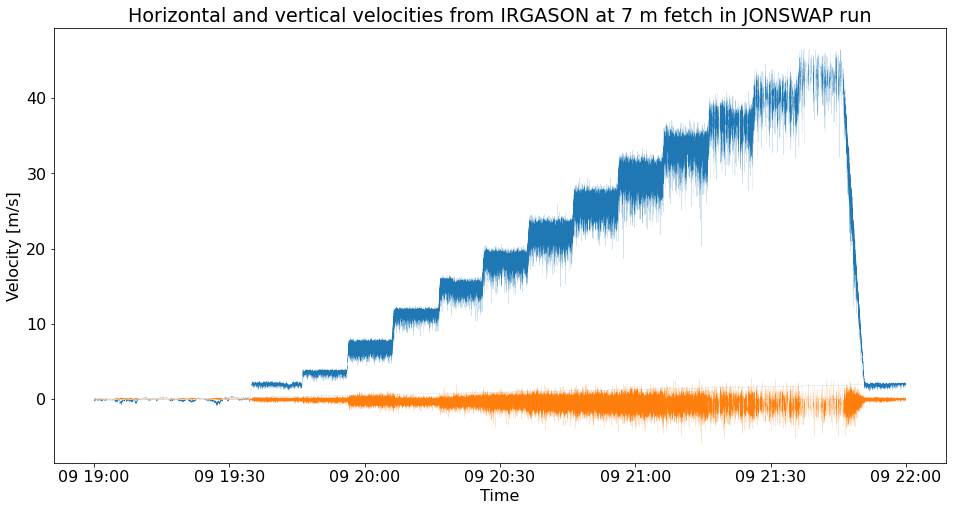

In [10]:
exp = experiments[1]
time, irg1, irg2 = exp['data']

fig = plt.figure(figsize=(16, 8))
plt.plot(time, irg1['u'], lw=0.1)
plt.plot(time, irg1['w'], lw=0.1)
plt.xlabel('Time')
plt.ylabel('Velocity [m/s]')
plt.title('Horizontal and vertical velocities from IRGASON at 7 m fetch in JONSWAP run')

(-5.0, 15.0)

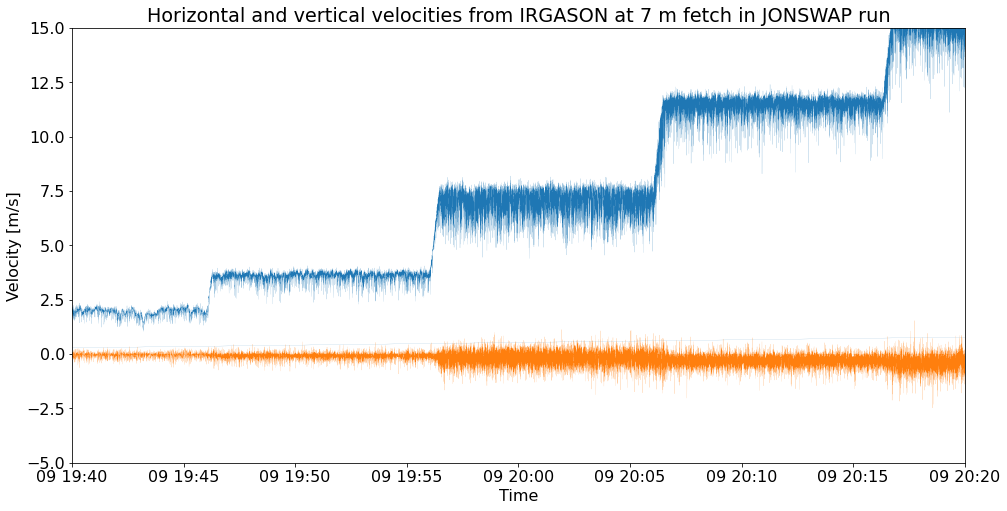

In [11]:
fig = plt.figure(figsize=(16, 8))
plt.plot(time, irg1['u'], lw=0.1)
plt.plot(time, irg1['w'], lw=0.1)
plt.xlabel('Time')
plt.ylabel('Velocity [m/s]')
plt.title('Horizontal and vertical velocities from IRGASON at 7 m fetch in JONSWAP run')
plt.xlim(datetime(2020, 1, 9, 19, 40), datetime(2020, 1, 9, 20, 20))
plt.ylim(-5, 15)

## u and w fluctuations much higher at 15 Hz than at 10 or 20 Hz. What is going on here?

In [12]:
def velocity_cospectra(u, w):
    u -= np.nanmean(u)
    w -= np.nanmean(w)
    u[np.isnan(u)] = 0
    w[np.isnan(w)] = 0
    u, w = detrend(u), detrend(w)
    Suu, Sww, Suw, phase, coherence, f, df = cross_spectrum(u, w, 1 / 20, binsize=32)
    return Suu, Sww, Suw, f

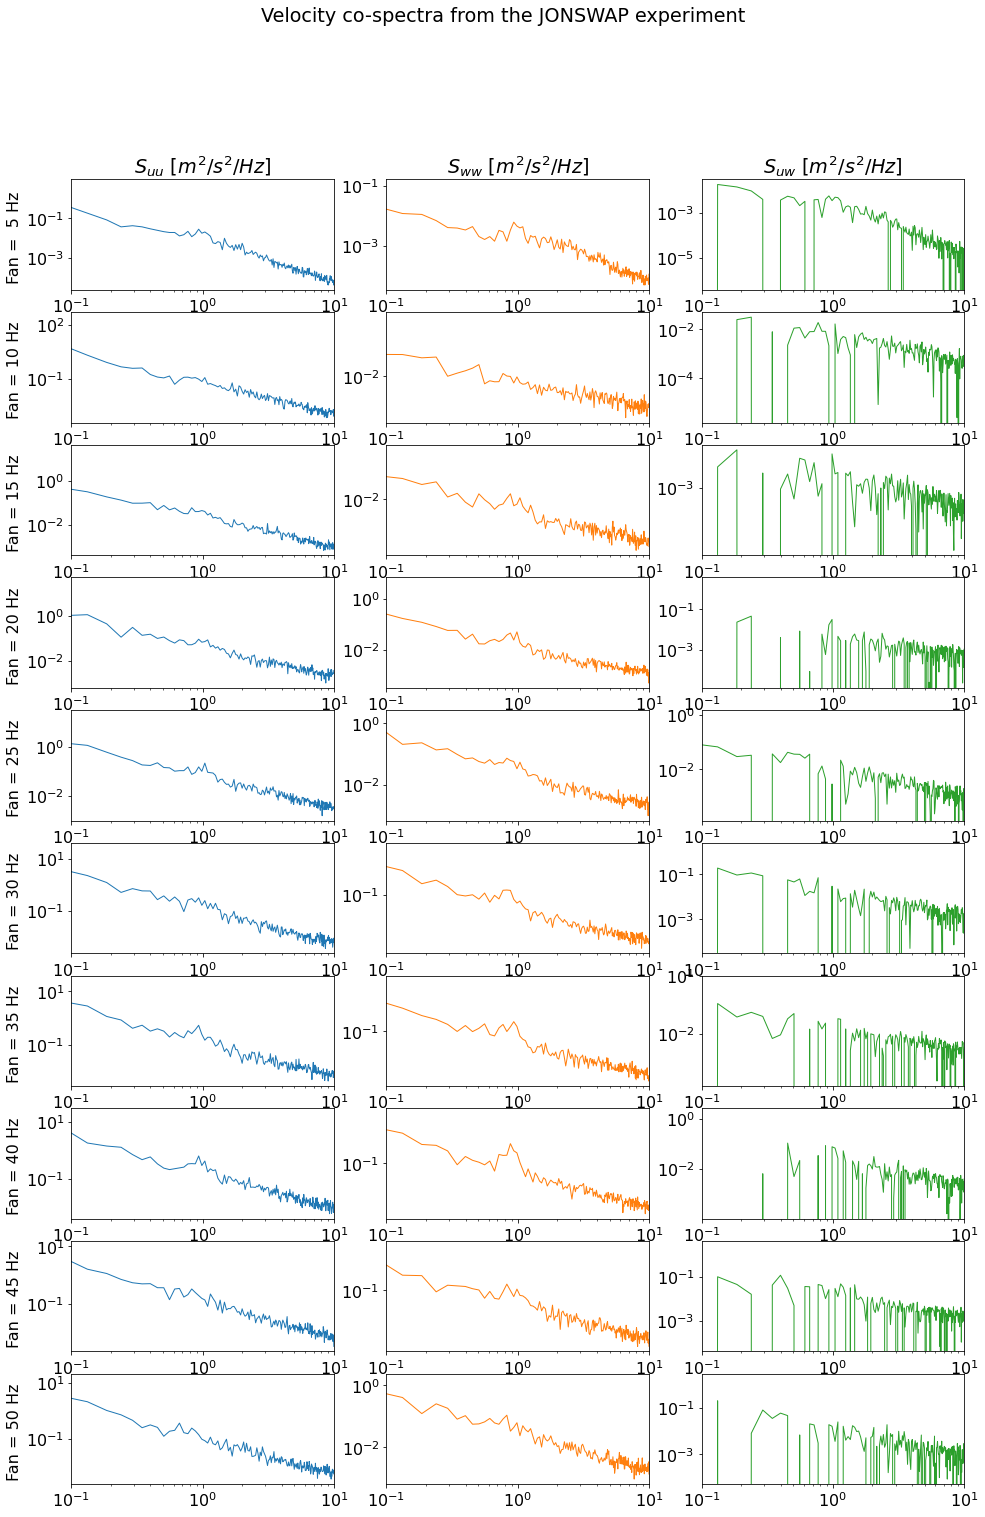

In [13]:
exp = experiments[1]
time, irg1, irg2 = exp['data']

fig = plt.figure(figsize=(16, 24))
fig.suptitle('Velocity co-spectra from the JONSWAP experiment')

for n, fan in enumerate(exp['fan']):
    if fan == 0:
        continue
    t0 = exp['start_time'] + n * timedelta(seconds=600)
    t1 = t0 + timedelta(seconds=600)
    mask = (time > t0) & (time <= t1)
    u, v, w = irg1['u'][mask][:], irg1['v'][mask][:], irg1['w'][mask][:]
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    Suu, Sww, Suw, f = velocity_cospectra(u, w)
    
    ax1 = plt.subplot2grid((10, 3), (n - 1, 0))
    ax2 = plt.subplot2grid((10, 3), (n - 1, 1))
    ax3 = plt.subplot2grid((10, 3), (n - 1, 2))
    
    ax1.loglog(f, Suu / f, lw=1, color='tab:blue')
    ax2.loglog(f, Sww / f, lw=1, color='tab:orange')
    ax3.loglog(f, Suw / f, lw=1, color='tab:green')
    
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(1e-1, 1e1)
    
    if fan == 5:
        ax1.set_title('$S_{uu}$ [$m^2/s^2/Hz$]')
        ax2.set_title('$S_{ww}$ [$m^2/s^2/Hz$]')
        ax3.set_title('$S_{uw}$ [$m^2/s^2/Hz$]')
        
    ax1.set_ylabel('Fan = %2i Hz ' % fan)

## Along-tank pressure gradient

In [14]:
pexperiments = [
    {'name': 'windonly_neutral', 'start_time': datetime(2019, 12, 3, 17, 30)},
    {'name': 'jonswap_stable', 'start_time': datetime(2020, 1, 9, 19, 36)},
    {'name': 'jonswap_unstable', 'start_time': datetime(2020, 1, 10, 2, 40)},
    {'name': 'monochromatic_unstable', 'start_time': datetime(2020, 1, 10, 19, 48)}
]

data = pd.read_csv(DATAPATH + '/scanivalve/scanivalve_' + pexperiments[3]['name'] + '.csv')
time = data['FTime']

fan = range(0, 55, 5)
x = fetch['static_pressure']
run_seconds = 600

start_time = datetime(2019, 12, 3, 17, 30)

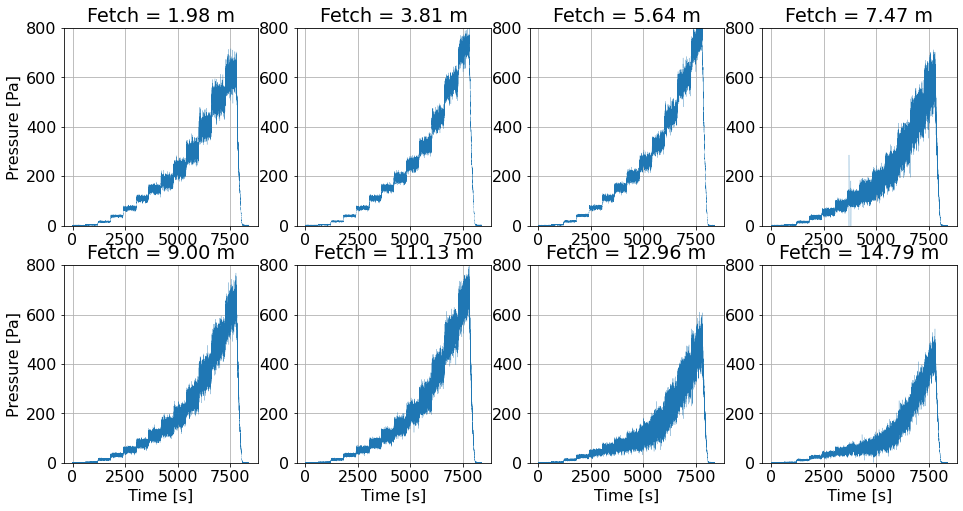

In [15]:
fig = plt.figure(figsize=(16, 8))
for j in range(2):
    for i in range(4):
        ax = plt.subplot2grid((2, 4), (j, i))
        pressure_index = j * 4 + i + 1
        ax.plot(time, data['%2.2i' % pressure_index + 'Press'], lw=0.2)
        plt.title('Fetch = %.2f m' % x[pressure_index - 1])
        plt.grid(True)
        plt.ylim(0, 800)
        if i == 0: plt.ylabel('Pressure [Pa]')
        if j == 1: plt.xlabel('Time [s]')

## Time-average pressure by run

In [16]:
labels = [
    'wind only, neutral',
    'JONSWAP, stable',
    'JONSWAP, unstable',
    'Monochromatic, unstable'
]

colors = ['g', 'y', 'r', 'm']

plotting exp windonly_neutral
plotting exp jonswap_stable
plotting exp jonswap_unstable
plotting exp monochromatic_unstable


Text(0.5, 0.98, 'Static pressure, ceiling, as function of fetch and experiment')

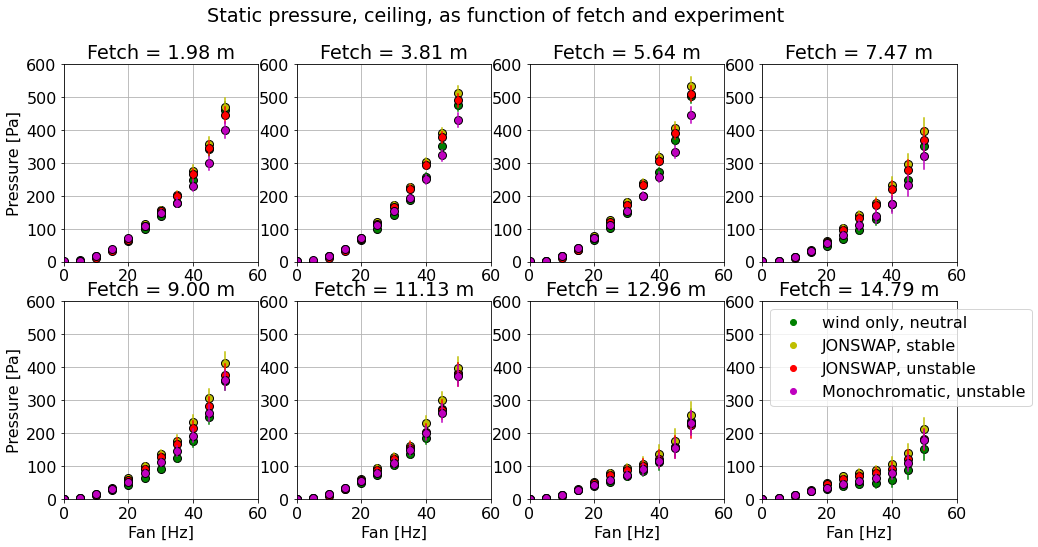

In [17]:
fan = range(0, 55, 5)

# 9-minute time windows for each run; 
# we exclude the first minute (thus 9 and not 10) due to fan spinup
t0 = [n * run_seconds + 60 for n in range(len(fan))]
t1 = [(n + 1) * run_seconds for n in range(len(fan))]

fig = plt.figure(figsize=(16, 8))
axes = []
for j in range(2):
    for i in range(4):
        ax = plt.subplot2grid((2, 4), (j, i))
        axes.append(ax)
        plt.grid(True)
        plt.xlim(0, 60)
        plt.ylim(0, 600)
        if i == 0: plt.ylabel('Pressure [Pa]')
        if j == 1: plt.xlabel('Fan [Hz]')
            
for nexp, pexp in enumerate(pexperiments):

    print('plotting exp ' + pexp['name'])
    data = pd.read_csv(DATAPATH + '/scanivalve/scanivalve_' + pexp['name'] + '.csv')
    time = data['FTime']
    
    for j in range(2):
        for i in range(4):
            ax = axes[j * 4 + i]
            pressure_index = j * 4 + i + 1
            pmean, pstd = [], []
            for n in range(len(fan)):
                mask = (time >= t0[n]) & (time <= t1[n])
                pres = data['%2.2iPress' % pressure_index][mask]
                pmean.append(np.mean(pres))
                pstd.append(np.std(pres))
            ax.plot(fan, pmean, marker='o', color=colors[nexp], ms=8, mec='k', linestyle='')
            for n in range(len(fan)):
                ax.plot([fan[n], fan[n]], [pmean[n] - pstd[n], pmean[n] + pstd[n]], color=colors[nexp])
            ax.set_title('Fetch = %.2f m' % x[pressure_index - 1])

ax = axes[-1]
for nexp, pexp in enumerate(pexperiments):
    ax.plot(np.nan, np.nan, colors[nexp] + 'o', label=labels[nexp])
ax.legend(loc='upper left')

fig.suptitle('Static pressure, ceiling, as function of fetch and experiment')

In [18]:
pmean = np.zeros((len(pexperiments), len(fan), 8))
pstd = np.zeros((len(pexperiments), len(fan), 8))
for i in range(8):
    for nexp, pexp in enumerate(pexperiments):
        data = pd.read_csv(DATAPATH + '/scanivalve/scanivalve_' + pexp['name'] + '.csv')
        time = data['FTime']
        for nrun, runs in enumerate(fan):
            mask = (time >= t0[nrun]) & (time <= t1[nrun])
            pres = data['%2.2iPress' % (i + 1)][mask]
            pmean[nexp,nrun,i] = np.mean(pres)
            pstd[nexp,nrun,i] = np.std(pres)

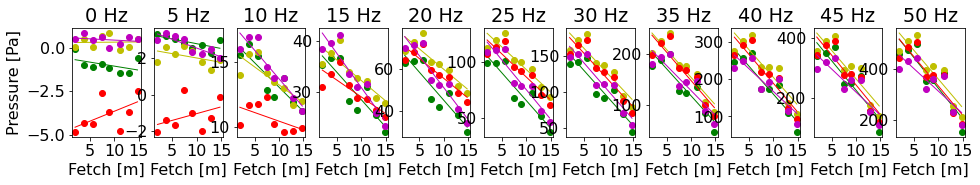

In [19]:
fig = plt.figure(figsize=(16, 2))
dpdx = np.zeros((len(pexperiments), len(fan)))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    for nexp, pexp in enumerate(pexperiments):
        plt.plot(x, pmean[nexp,n,:], colors[nexp] + 'o')
        p = np.polyfit(x, pmean[nexp,n,:], 1)
        fit = np.polyval(p, x)
        plt.plot(x, fit, colors[nexp] + '-', lw=1)
        plt.xlabel('Fetch [m]')
        if n == 0: plt.ylabel('Pressure [Pa]')
        plt.title(str(fan[n]) + ' Hz')
        dpdx[nexp, n] = (fit[-1] - fit[0]) / (x[-1] - x[0])

## Along-tank pressure gradient


$$
\tau = \rho_w g H \dfrac{\partial h}{\partial x} 
     + H \underline{\mathbf{\dfrac{\partial p}{\partial x}}}
     + \dfrac{\partial S_{xx}}{\partial x}
$$

Text(0.5, 1.0, 'Along-tank pressure gradient')

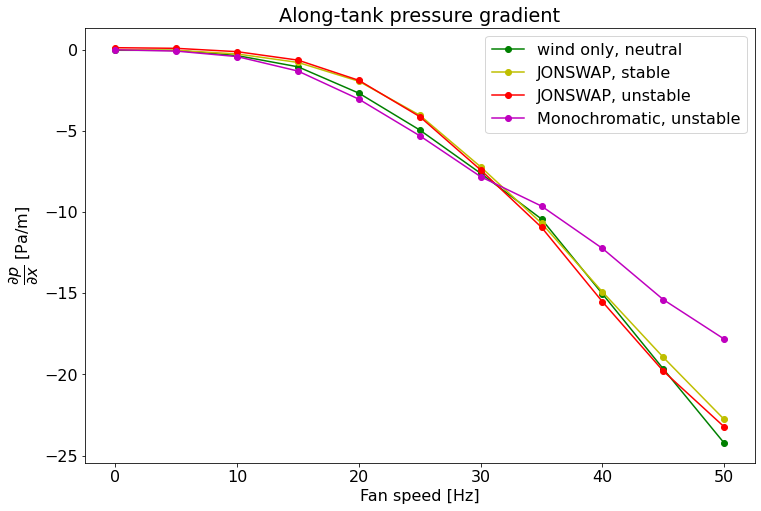

In [20]:
plt.figure(figsize=(12, 8))
for n, exp in enumerate(experiments):
    plt.plot(fan, dpdx[n,:], color=colors[n], marker='o', label=labels[n])
plt.legend()
plt.xlabel('Fan speed [Hz]')
plt.ylabel(r'$\dfrac{\partial p}{\partial x}$ [Pa/m]')
plt.title('Along-tank pressure gradient')

## Mean slope and radiation stress gradient from UDM

In [21]:
def elevation_from_udm(x, max_value=0.3, max_jump=0.08, interpolation_method='polynomial'):
    xx = np.mean(x[:20 * 600]) - x[:] # offset first 10 minutes
    xdiff = xx[1:] - xx[:-1]
    xx[1:][np.abs(xdiff) > max_jump] = np.nan # difference between 2 points should not exceed max_jump
    xx[np.abs(xx) > max_value] = np.nan # elevation should not go below min_trough
    return np.array(pd.DataFrame(data=xx).interpolate(method=interpolation_method, order=3))[:,0]

def cp_cg(F, f, depth):
    """Return phase and group speeds for a wave spectrum."""
    w = 2 * np.pi * f
    k = w2k(w, depth)[0]
    cp = w[1:] / k[1:]
    cg = np.diff(w) / np.diff(k)
    return cp, cg

GRAV = 9.8

def radiation_stress(F, f, df, depth, rhow=1000):
    """Returns radiation stress."""
    cp, cg = cp_cg(F, f, depth)
    rad_stress_fac = 2 * cg / cp - 0.5
    return rhow * GRAV * np.sum(rad_stress_fac * F[1:] * df)

def stress_from_momentum_budget(H, dhdx, dSxxdx, dpdx, taub, rhow):
    """Returns the stress estimate from momentum budget components."""
    return rhow * GRAV * H * dhdx + H * dpdx + dSxxdx - taub

In [22]:
uexperiments = [
    {'start_time': datetime(2019, 12,  3, 17, 30), 'fan': range(0, 55, 5)}, # wind-only, neutral, fresh, 0 - 50 Hz
    {'start_time': datetime(2020,  1,  9, 19, 36), 'fan': range(0, 55, 5)}, # wind + JONSWAP, stable, salt, 0 - 60 Hz 
    {'start_time': datetime(2020,  1, 10,  2, 40), 'fan': range(0, 55, 5)}, # wind + JONSWAP, unstable, salt, 0 - 60 Hz
    {'start_time': datetime(2020,  1, 10, 19, 48), 'fan': range(0, 55, 5)}, # wind + monochromatic, unstable, salt, 0 - 60 Hz
]

In [23]:
# map UDM arrays to sequential positions in the tank
udm_all = []

for nexp, uexp in enumerate(uexperiments):
    files = glob.glob(DATAPATH + '/' + uexp['start_time'].strftime('%Y%m%d') + '/TOA5_SUSTAIN_ELEVx6*.dat')
    utime, u1, u2, u3, u4, u5, u6 = read_udm_from_toa5(files)
    udm = np.zeros((x.size, utime.size))
    udm[0,:] = elevation_from_udm(u6[:])
    udm[1,:] = elevation_from_udm(u5[:])
    udm[2,:] = elevation_from_udm(u1[:])
    udm[3,:] = elevation_from_udm(u3[:])
    udm[4,:] = elevation_from_udm(u4[:])
    udm_all.append(udm)

Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1399_2019_12_03_1700.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1400_2019_12_03_1800.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1401_2019_12_03_1900.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2250_2020_01_09_1900.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2252_2020_01_09_2100.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2251_2020_01_09_2000.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2277_2020_01_10_2100.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2259_2020_01_10_0400.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2275_2020_01_10_1900.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2276_2020_01_10_2000.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2257_2020_01_10_0200.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2258_2020_01_10_0300.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2277_2020_01_10_2100.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2259_2020_01_10_0400.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2275_2020_01_10_1900.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2

In [24]:
nexps = len(uexperiments)
nruns = len(range(0, 55, 5))
nfetch = len(fetch['udm'])

h = np.zeros((nexps, nruns, nfetch))
Sxx = np.zeros((nexps, nruns, nfetch))
dhdx = np.zeros((nexps, nruns))
dSxxdx = np.zeros((nexps, nruns))

for nexp, uexp in enumerate(uexperiments):
    files = glob.glob(DATAPATH + '/' + uexp['start_time'].strftime('%Y%m%d') + '/TOA5_SUSTAIN_ELEVx6*.dat')
    time_, u1, u2, u3, u4, u5, u6 = read_udm_from_toa5(files)
    start_time = uexp['start_time']
    end_time = start_time + timedelta(seconds=run_seconds * nruns)
    exp_time = (time_ >= start_time) & (time_ <= end_time)
    utime = time_[exp_time]

    x = fetch['udm']
    # map UDM arrays to sequential positions in the tank
    udm = np.zeros((x.size, utime.size))
    udm[0,:] = elevation_from_udm(u6[exp_time])
    udm[1,:] = elevation_from_udm(u5[exp_time])
    udm[2,:] = elevation_from_udm(u1[exp_time])
    udm[3,:] = elevation_from_udm(u3[exp_time])
    udm[4,:] = elevation_from_udm(u4[exp_time])
    
    # 9-minute time windows for each run; 
    # we exclude the first minute (thus 9 and not 10) due to fan spinup
    t0 = [start_time + timedelta(seconds=n * run_seconds + 60) for n in range(len(fan))]
    t1 = [t0[n] + timedelta(seconds=run_seconds - 60) for n in range(nruns)] 
    
    for nrun in range(nruns):
        mask = (utime >= t0[nrun]) & (utime <= t1[nrun])
        for i in range(nfetch):
            h[nexp,nrun,i] = np.mean(udm[i,mask][:-1])
            e = detrend(udm[i,mask][:-1])
            F, f, df = power_spectrum(e, 1 / 20, binsize=1)
            fmask = (f > 0.5) & (f < 2)
            Sxx[nexp,nrun,i] = radiation_stress(F[fmask], f[fmask], df, 0.8, rhow=1000)
            
        x = fetch['udm']
        p = np.polyfit(x, h[nexp,nrun,:], 1)
        fit = np.polyval(p, x)
        dhdx[nexp,nrun] = (fit[-1] - fit[0]) / (x[-1] - x[0])
        
        p = np.polyfit(x, Sxx[nexp,nrun,:], 1)
        fit = np.polyval(p, x)
        dSxxdx[nexp,nrun] = (fit[-1] - fit[0]) / (x[-1] - x[0])
    
# apply offset so that all mean elevations are 0 m at fan = 0 Hz. 
for nexp in range(len(uexperiments)):
    for nfetch in range(5):
        h[nexp,:,nfetch] -= h[nexp,0,nfetch]
        
# fix first 2 points in windonly experiment:
h[0,:3,:] = h[1,:3,:]
h[0,3:,:] = h[0,3:,:] - h[0,3,:] + h[1,3,:]
    
for n in range(len(uexperiments)):
    dhdx[n,:] -= dhdx[n,0]
    dSxxdx[n,:] -= dSxxdx[n,0]
    dpdx[n,:] -= dpdx[n,0]

Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1399_2019_12_03_1700.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1400_2019_12_03_1800.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1401_2019_12_03_1900.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2250_2020_01_09_1900.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2252_2020_01_09_2100.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2251_2020_01_09_2000.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2277_2020_01_10_2100.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2259_2020_01_10_0400.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2275_2020_01_10_1900.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2276_2020_01_10_2000.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2257_2020_01_10_0200.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2258_2020_01_10_0300.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2277_2020_01_10_2100.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2259_2020_01_10_0400.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2275_2020_01_10_1900.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_2

## Mean water elevation as function of fan speed and fetch

Text(0.5, 0.98, 'Mean water elevation at 5 UDM locations in the tank')

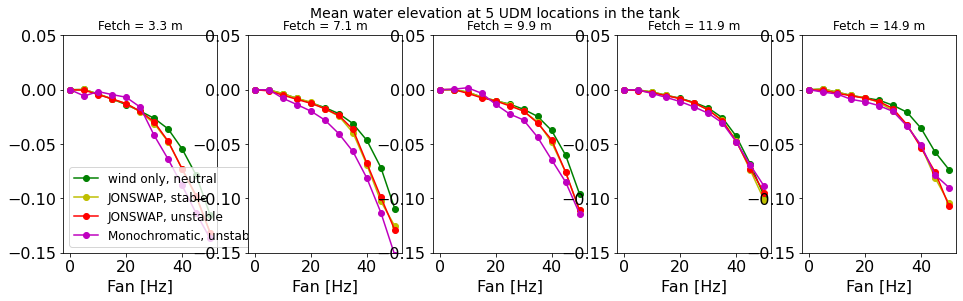

In [25]:
fig = plt.figure(figsize=(16, 4))
for nfetch, ffetch in enumerate(x):
    ax = plt.subplot2grid((1, x.size), (0, nfetch))
    plt.title('Fetch = %.1f m' % ffetch, fontsize=12)
    for nexp, uexp in enumerate(uexperiments):
        ax.plot(fan, h[nexp,:,nfetch], marker='o', color=colors[nexp], label=labels[nexp])
    if nfetch == 0:
        plt.legend(prop={'size': 12})
    plt.xlabel('Fan [Hz]')
    plt.ylim(-0.15, 0.05)
fig.suptitle('Mean water elevation at 5 UDM locations in the tank', fontsize=14)

## Mean water elevation slope

$$
\tau = \rho_w g H \underline{\mathbf{\dfrac{\partial h}{\partial x}}} 
     + H \dfrac{\partial p}{\partial x}
     + \dfrac{\partial S_{xx}}{\partial x}
$$

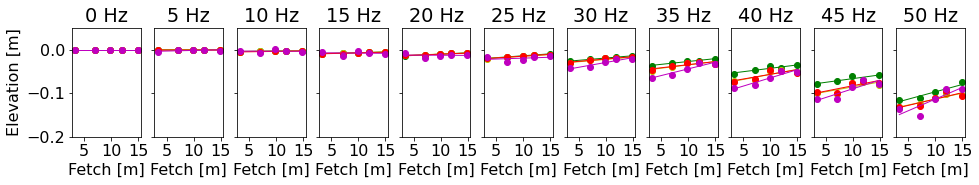

In [26]:
fan = range(0, 55, 5)
fig = plt.figure(figsize=(16, 2))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    for nexp, uexp in enumerate(uexperiments):
        plt.plot(x, h[nexp,n,:], colors[nexp] + 'o')
        p = np.polyfit(x, h[nexp,n,:], 1)
        fit = np.polyval(p, x)
        plt.plot(x, fit, colors[nexp] + '-', lw=1)
        plt.xlabel('Fetch [m]')
        plt.ylim(-0.2, 0.05)
        if n == 0: plt.ylabel('Elevation [m]')
        plt.title(str(fan[n]) + ' Hz')
        if n > 0:
            ax.set_yticklabels([])

(0.0, 50.0)

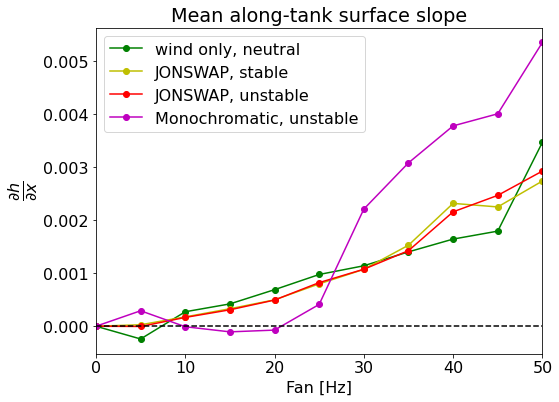

In [27]:
plt.figure(figsize=(8, 6))
for n, uexp in enumerate(uexperiments):
    plt.plot(uexp['fan'], dhdx[n,:], marker='o', color=colors[n], label=labels[n])
plt.legend()
plt.plot([0, 50], [0, 0], 'k--')
plt.title('Mean along-tank surface slope')
plt.xlabel('Fan [Hz]')
plt.ylabel('$\dfrac{\partial h}{\partial x}$')
plt.xlim(0, 50)

## Radiation stress gradient

$$
\tau = \rho_w g H \dfrac{\partial h}{\partial x} 
     + H \dfrac{\partial p}{\partial x}
     + \underline{\mathbf{\dfrac{\partial S_{xx}}{\partial x}}}
$$

(0.0, 50.0)

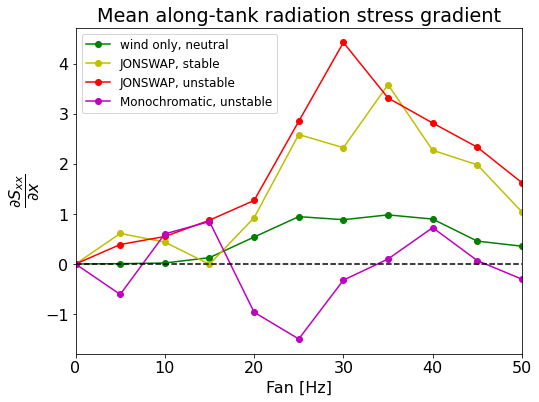

In [28]:
plt.figure(figsize=(8, 6))
for n, uexp in enumerate(uexperiments):
    plt.plot(uexp['fan'], dSxxdx[n,:], marker='o', color=colors[n], label=labels[n])
plt.legend(prop={'size': 12})
plt.plot([0, 50], [0, 0], 'k--')
plt.title('Mean along-tank radiation stress gradient')
plt.xlabel('Fan [Hz]')
plt.ylabel('$\dfrac{\partial S_{xx}}{\partial x}$')
plt.xlim(0, 50)

## Putting the momentum budget components together

$$
\tau = \rho_w g H \dfrac{\partial h}{\partial x} 
     + H \dfrac{\partial p}{\partial x}
     + \dfrac{\partial S_{xx}}{\partial x}
     - \tau_B
$$

In [29]:
H = np.mean(h, axis=2) + 0.8
rhow = 1e3

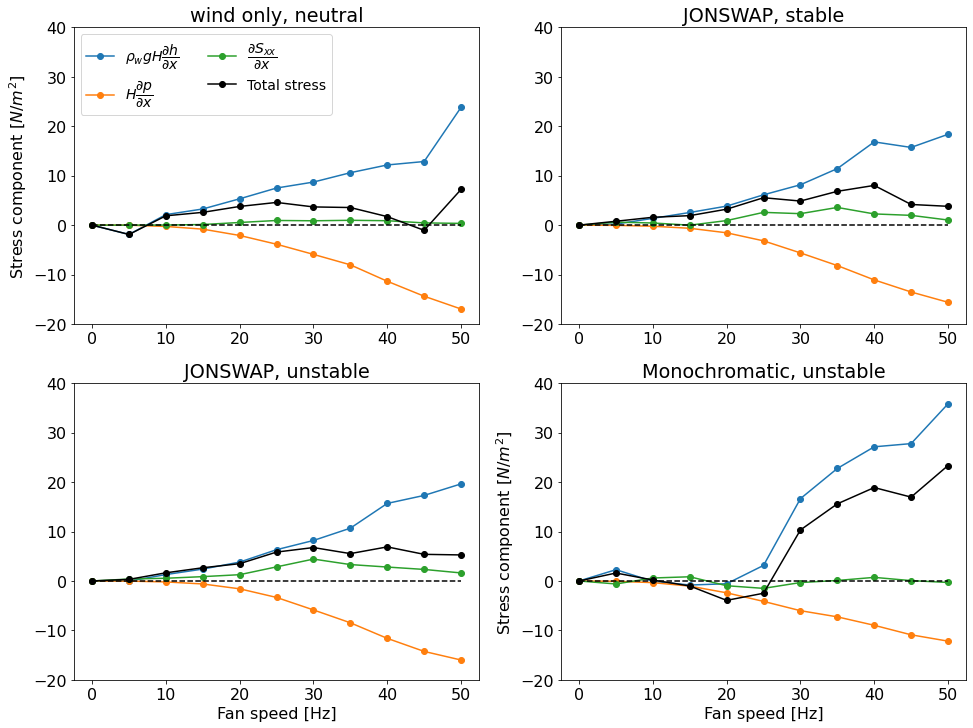

In [30]:
fig = plt.figure(figsize=(16, 12))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

axes = [ax1, ax2, ax3, ax4]

for n, ax in enumerate(axes):
    ax.plot(fan, rhow * GRAV * H[n,:] * dhdx[n,:], marker='o', label=r'$\rho_w g H \dfrac{\partial h}{\partial x}$')
    ax.plot(fan, H[n,:] * dpdx[n,:], marker='o', label='$H\dfrac{\partial p}{\partial x}$')
    ax.plot(fan, dSxxdx[n,:], marker='o', label='$\dfrac{\partial S_{xx}}{\partial x}$')
    ax.plot(fan, rhow * GRAV * H[n,:] * dhdx[n,:] + H[n,:] * dpdx[n,:] + dSxxdx[n,:], 'k-', marker='o', label='Total stress')
    ax.set_title(labels[n])
    if n == 0:
        ax.legend(ncol=2, prop={'size': 14})
    if n in [2, 3]:
        ax.set_xlabel('Fan speed [Hz]')
    if n in [0, 3]:
        ax.set_ylabel('Stress component [$N/m^2$]')
    ax.plot([0, 50], [0, 0], 'k--')
    ax.set_ylim(-20, 40)

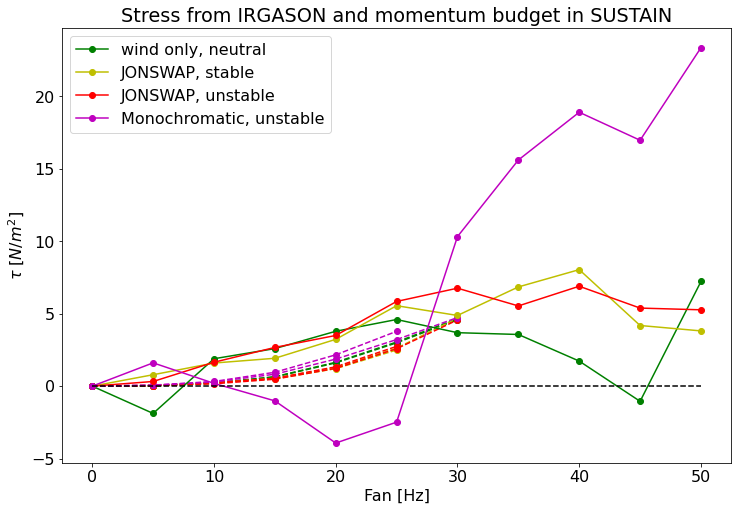

In [31]:
z_surface = 0.75
z_irgason = 1.35
dtaudz = 1.5 * 13 / 20 * dpdx # first guess based on HIDRAG data

plt.figure(figsize=(12, 8))
for n, exp in enumerate(experiments):
    tau_irg1 = 1.2 * np.mean(exp['uw1'], 1)
    tau_irg2 = 1.2 * np.mean(exp['uw2'], 1)
    taus_irg1 = tau_irg1 - dtaudz[n,:] * (z_irgason - z_surface)
    taus_irg2 = tau_irg2 - dtaudz[n,:] * (z_irgason - z_surface)
    plt.plot(exp['fan'], taus_irg1, color=colors[n], marker='o', linestyle='--')
    plt.plot(exp['fan'], taus_irg2, color=colors[n], marker='o', linestyle='--')

for n, uexp in enumerate(uexperiments):
    tau = rhow * GRAV * H[n,:] * dhdx[n,:] + H[n,:] * dpdx[n,:] + dSxxdx[n,:]
    plt.plot(uexp['fan'], tau, marker='o', color=colors[n], label=labels[n])

plt.legend()
plt.xlabel('Fan [Hz]')
plt.ylabel(r"$\tau$ [$N/m^2$]")
plt.title('Stress from IRGASON and momentum budget in SUSTAIN')
plt.plot([0, 50], [0, 0], 'k--')